# Purpose:
- analyze z-drift with or without motion correction
    - Using hpc (sbatch_omc_zdrift.py)
- Analyze the output data


In [1]:
import numpy as np
from pystackreg import StackReg
from pathlib import Path
from glob import glob
import tifffile
import h5py
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask import delayed, compute
import napari

# Dev work for finding matched zstack

In [2]:
def rolling_average_zstack(zstack, rolling_window_flank=2):
    new_zstack = np.zeros(zstack.shape)
    for i in range(zstack.shape[0]):
        new_zstack[i] = np.mean(zstack[max(0, i-rolling_window_flank) : min(zstack.shape[0], i+rolling_window_flank), :, :],
                                axis=0)
    return new_zstack


def get_matched_zstack(emf_fn, ops_fn, zstack_dir, num_planes_around=40):
    ''' 
    
    
    Notes
    - Rolling average of z-stacks was not enough.
    '''
    ops = np.load(ops_fn, allow_pickle=True).item()
    y_roll_bottom = np.min(ops['reg_result'][4][0])
    y_roll_top = np.max(ops['reg_result'][4][0])
    x_roll_left = np.max(ops['reg_result'][4][1])
    x_roll_right = np.min(ops['reg_result'][4][1])
    if y_roll_bottom >= 0:
        y_roll_bottom = -1
    if x_roll_right >= 0:
        x_roll_right = -1

    zstack_fn_list = glob(str(zstack_dir /'ophys_experiment_*_local_z_stack.tiff'))
    center_zstacks = []
    for zstack_fn in zstack_fn_list:
        zstack = tifffile.imread(zstack_fn)
        new_zstack = rolling_average_zstack(zstack)
        center_ind = int(np.floor(new_zstack.shape[0]/2))
        center_zstack = new_zstack[center_ind - num_planes_around//2 : center_ind + num_planes_around//2+1]
        center_zstack = center_zstack[:, y_roll_top:y_roll_bottom, x_roll_left:x_roll_right]

        center_zstacks.append(center_zstack)
    first_emf = tifffile.imread(emf_fn)[0, y_roll_top:y_roll_bottom, x_roll_left:x_roll_right]
    # first_emf = tifffile.imread(emf_fn)[0]
    
    assert first_emf.min() > 0
    valid_pix_threshold = first_emf.min()/10
    num_pix_threshold = first_emf.shape[0] * first_emf.shape[1] / 3

    sr = StackReg(StackReg.AFFINE)
    corrcoef = np.zeros((len(center_zstacks), center_zstacks[0].shape[0]))
    
    for i, zstack in enumerate(center_zstacks):
        temp_cc = []
        tmat_list = []
        for j, zstack_plane in enumerate(zstack):
            tmat = sr.register(zstack_plane, first_emf)
            emf_reg = sr.transform(first_emf, tmat=tmat)            
            valid_y, valid_x = np.where(emf_reg > valid_pix_threshold)
            if len(valid_y) > num_pix_threshold:
                temp_cc.append(np.corrcoef(zstack_plane.flatten(), emf_reg.flatten())[0,1])
                tmat_list.append(tmat)
            else:
                temp_cc.append(0)
                tmat_list.append(np.eye(3))
        temp_ind = np.argmax(temp_cc)
        best_tmat = tmat_list[temp_ind]
        emf_reg = sr.transform(first_emf, tmat=best_tmat)
        for j, zstack_plane in enumerate(zstack):
            corrcoef[i,j] = np.corrcoef(zstack_plane.flatten(), emf_reg.flatten())[0,1]
    matched_ind = np.argmax(np.mean(corrcoef, axis=1))
    return matched_ind, zstack_fn_list, corrcoef

In [ ]:
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_721291\test_240515_721291')

emf_fn_list = glob(str(data_dir / '*_nomotioncorrection_timeseries_*_emf.tif'))
zstack_dir = data_dir / 'ophys_session_1364637859'

client = Client()
task = []
tasks = [delayed(get_matched_zstack)(fn, fn[:-7]+'ops.npy', zstack_dir) for fn in emf_fn_list]
results = compute(*tasks, num_workers = 8)
client.close()

matched_zstack_inds = [r[0] for r in results]
assert len(matched_zstack_inds) == len(np.unique(matched_zstack_inds))



## using scanimage header file to match the depth
- Cannot do this

In [3]:
from ScanImageTiffReader import ScanImageTiffReader
import json


def _extract_dict_from_si_string(string):
    """Parse the 'SI' variables from a scanimage metadata string"""

    lines = string.split('\n')
    data_dict = {}
    for line in lines:
        if line.strip():  # Check if the line is not empty
            key, value = line.split(' = ')
            key = key.strip()
            if value.strip() == 'true':
                value = True
            elif value.strip() == 'false':
                value = False
            else:
                value = value.strip().strip("'")  # Remove leading/trailing whitespace and single quotes
            data_dict[key] = value

    json_data = json.dumps(data_dict, indent=2)
    loaded_data_dict = json.loads(json_data)
    return loaded_data_dict


def _str_to_int_list(string):
    return [int(s) for s in string.strip('[]').split()]


def _str_to_bool_list(string):
    return [bool(s) for s in string.strip('[]').split()]

def metadata_from_scanimage_tif(stack_path):
    """Extract metadata from ScanImage tiff stack

    Dev notes:
    Seems awkward to parse this way
    Depends on ScanImageTiffReader

    Parameters
    ----------
    stack_path : str
        Path to tiff stack

    Returns
    -------
    dict
        stack_metadata: important metadata extracted from scanimage tiff header
    dict
        si_metadata: all scanimge metadata. Each value still a string, so convert if needed.
    dict
        roi_groups_dict: 
    """
    with ScanImageTiffReader(str(stack_path)) as reader:
        md_string = reader.metadata()

    # split si & roi groups, prep for seprate parse
    s = md_string.split("\n{")
    rg_str = "{" + s[1]
    si_str = s[0]

    # parse 1: extract keys and values, dump, then load again
    si_metadata = _extract_dict_from_si_string(si_str)
    # parse 2: json loads works hurray
    roi_groups_dict = json.loads(rg_str)

    stack_metadata = {}
    stack_metadata['num_slices'] = int(si_metadata['SI.hStackManager.actualNumSlices'])
    stack_metadata['num_volumes'] = int(si_metadata['SI.hStackManager.actualNumVolumes'])
    stack_metadata['frames_per_slice'] = int(si_metadata['SI.hStackManager.framesPerSlice'])
    stack_metadata['z_steps'] = _str_to_int_list(si_metadata['SI.hStackManager.zs'])
    stack_metadata['actuator'] = si_metadata['SI.hStackManager.stackActuator']
    stack_metadata['num_channels'] = sum(_str_to_bool_list(si_metadata['SI.hPmts.powersOn']))
    stack_metadata['z_step_size'] = int(si_metadata['SI.hStackManager.actualStackZStepSize'])

    return stack_metadata, si_metadata, roi_groups_dict

In [4]:
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_721291\test_240515_721291')

si_fn = '240515_721291_global_30min_1366658085_timeseries_00006.tif'
si_fn = data_dir / si_fn
stack_metadata, si_metadata, roi_groups_dict = metadata_from_scanimage_tif(si_fn)

In [7]:
# si_meata and roi_groups_dict saved
# none of them has depth matching metadata

## Too low correlation?

In [3]:
# visual inspection
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_721291\test_240515_721291')

emf_fn_list = glob(str(data_dir / '*_nomotioncorrection_timeseries_*_emf.tif'))
zstack_dir = data_dir / 'ophys_session_1364637859'

In [31]:
emf_fn = Path(emf_fn_list[0])
fn_base = emf_fn.name.split('.')[0]
zdrift_fn = emf_fn.parent / f'{fn_base}_zdrift.h5'
with h5py.File(zdrift_fn, 'r') as h:
    corrcoef_zstack_finding = h['corrcoef_zstack_finding'][:]
    matched_zstack_fn = Path('/' + h['matched_zstack_fn'][()].decode('utf-8', errors='replace'))
    corrcoef = h['corrcoef'][:]
    tmat = h['tmat'][:]
    print(h.keys())


<KeysViewHDF5 ['corrcoef', 'corrcoef_zstack_finding', 'matched_inds', 'matched_zstack_fn', 'tmat', 'zstack_fn_list']>


In [19]:
matched_zstack_fn

WindowsPath('//allen/programs/mindscope/workgroups/learning/pilots/online_motion_correction/mouse_721291/test_240515_721291/ophys_session_1364637859/ophys_experiment_1364815944_local_z_stack.tiff')

In [20]:
ops_fn = emf_fn.parent / f'{fn_base[:-3]}ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()

y_roll_top = np.max(ops['reg_result'][4][0])
y_roll_bottom = np.min(ops['reg_result'][4][0])    
x_roll_left = np.max(ops['reg_result'][4][1])
x_roll_right = np.min(ops['reg_result'][4][1])
if y_roll_bottom >= 0:
    y_roll_bottom = -1
if x_roll_right >= 0:
    x_roll_right = -1


emf = tifffile.imread(emf_fn)[:, y_roll_top:y_roll_bottom, x_roll_left:x_roll_right]
zstack = tifffile.imread(matched_zstack_fn)[:, y_roll_top:y_roll_bottom, x_roll_left:x_roll_right]
new_zstack = rolling_average_zstack(zstack)

In [21]:
sr = StackReg(StackReg.RIGID_BODY)
emf_reg = np.zeros(emf.shape)
for fi, fov in enumerate(emf):
    emf_reg[fi] = sr.transform(fov, tmat=tmat)

In [24]:
viewer = napari.Viewer()
for fi, fov in enumerate(emf_reg):
    viewer.add_image(fov, name=f'fov {fi}')
viewer.add_image(new_zstack, name='zstack')

<Image layer 'zstack' at 0x20442dec790>

In [41]:
sr = StackReg(StackReg.RIGID_BODY)
valid_pix_threshold = emf.min()/10
num_pix_threshold = emf.shape[1] * emf.shape[2] / 3
tmat_list = []
fov_reg_list = []
for i, fov in enumerate(emf):
    temp_tmat = []
    temp_cc = []
    for j, zplane in enumerate(new_zstack):
        tmat = sr.register(zplane, fov)
        fov_reg = sr.transform(fov, tmat=tmat)
        valid_y, valid_x = np.where(fov_reg > valid_pix_threshold)
        if len(valid_y) > num_pix_threshold:
            temp_cc.append(np.corrcoef(zplane[valid_y, valid_x].flatten(),
                                       fov_reg[valid_y, valid_x].flatten())[0,1])
            temp_tmat.append(tmat)
        else:
            temp_cc.append(0)
            temp_tmat.append(np.eye(3))
    temp_ind = np.argmax(temp_cc)
    tmat = temp_tmat[temp_ind]
    tmat_list.append(tmat)
    fov_reg = sr.transform(fov, tmat=tmat)
    fov_reg_list.append(fov_reg)
    valid_y, valid_x = np.where(fov_reg > valid_pix_threshold)
    
    for j, zplane in enumerate(new_zstack):
        corrcoef[i,j] = np.corrcoef(zplane[valid_y, valid_x].flatten(),
                                    fov_reg[valid_y, valid_x].flatten())[0,1]
matched_inds = np.argmax(corrcoef, axis=1)

In [96]:
tiffn = data_dir / '240515_721291_nomotioncorrection_timeseries_30min_01_emf.tif'
emf = tifffile.imread(tiffn)

In [44]:
matched_inds

array([29, 29, 31, 32, 32, 39, 41, 42, 42, 44], dtype=int64)

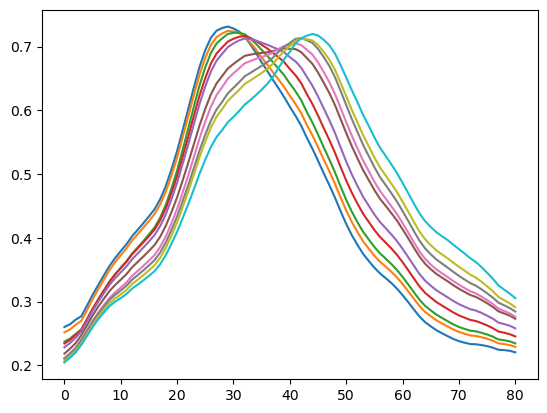

In [46]:
fig, ax = plt.subplots()
for ci, corr in enumerate(corrcoef):
    ax.plot(corr, label=f'epoch {ci}')

In [45]:
[np.max(corr) for corr in corrcoef]

[0.7315111017324019,
 0.7246473655277912,
 0.7217585089465423,
 0.7165068256005256,
 0.7127218905815244,
 0.6973412534352662,
 0.705018104897223,
 0.713271206017413,
 0.7125455092570154,
 0.7198273314268288]

In [ ]:
fov_reg = sr.transform(fov, tmat=tmat)

In [38]:
fov_reg_list = []
for i in range(emf.shape[0]):
    fov = emf[i]
    tmat = tmat_list[i]
    fov_reg = sr.transform(fov, tmat=tmat)
    fov_reg_list.append(fov_reg)

In [43]:
viewer = napari.Viewer()
for i in range(len(fov_reg_list)):
    viewer.add_image(fov_reg_list[i], name=f'epoch {i}')
viewer.add_image(new_zstack, name='zstack')

<Image layer 'zstack' at 0x20459af82e0>

# Analysis

In [47]:
# manual curating of matched z-stack depths using mouse-qc
opid_depths = {'1364815941': 150,
'1364815944': 188,
'1364815946': 110,
'1364815948': 228,
'1364815949': 74,
'1364815951': 268,
'1364815952': 28,
'1364815955': 296}
depth_value_sorted = np.sort(list(opid_depths.values()))

## x-y drift

In [48]:
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_721291\test_240515_721291')
ops_fn_list = glob(str(data_dir / '*_timeseries_*_ops.npy'))

fn_list = glob(str(data_dir / '*_timeseries_*.tif'))
emf_fn_list = glob(str(data_dir / '*_timeseries_*_emf.tif'))
fn_list = [fn for fn in fn_list if fn not in emf_fn_list]
fn_base = [Path(fn).name.split('.')[0] for fn in fn_list]
fn_base

['240515_721291_global_30min_1366658085_timeseries_00006',
 '240515_721291_nomotioncorrection_timeseries_30min']

In [49]:
mc_i = 0
nomc_i = 1
omc_fn_list = [fn for fn in emf_fn_list if fn_base[mc_i] in fn]
nomc_fn_list = [fn for fn in emf_fn_list if fn_base[nomc_i] in fn]

In [56]:
ops_fn = ops_fn_list[8]
ops = np.load(ops_fn, allow_pickle=True).item()
print(ops.keys())

dict_keys(['suite2p_version', 'look_one_level_down', 'fast_disk', 'delete_bin', 'mesoscan', 'bruker', 'bruker_bidirectional', 'h5py', 'h5py_key', 'nwb_file', 'nwb_driver', 'nwb_series', 'save_path0', 'save_folder', 'subfolders', 'move_bin', 'nplanes', 'nchannels', 'functional_chan', 'tau', 'fs', 'force_sktiff', 'frames_include', 'multiplane_parallel', 'ignore_flyback', 'preclassify', 'save_mat', 'save_NWB', 'combined', 'aspect', 'do_bidiphase', 'bidiphase', 'bidi_corrected', 'do_registration', 'two_step_registration', 'keep_movie_raw', 'nimg_init', 'batch_size', 'maxregshift', 'align_by_chan', 'reg_tif', 'reg_tif_chan2', 'subpixel', 'smooth_sigma_time', 'smooth_sigma', 'th_badframes', 'norm_frames', 'force_refImg', 'pad_fft', 'nonrigid', 'block_size', 'snr_thresh', 'maxregshiftNR', '1Preg', 'spatial_hp_reg', 'pre_smooth', 'spatial_taper', 'roidetect', 'spikedetect', 'sparse_mode', 'spatial_scale', 'connected', 'nbinned', 'max_iterations', 'threshold_scaling', 'max_overlap', 'high_pass'

In [58]:
# find matched split inds between omc and nomc
omc_parent_opid = []
for fn in omc_fn_list:
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        mc_matched_zstack_fn = h['matched_zstack_fn'][()]
        parent_opid = Path(mc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    omc_parent_opid.append(parent_opid)
nomc_parent_opid = []
for fn in nomc_fn_list:
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        nomc_matched_zstack_fn = h['matched_zstack_fn'][()]
        parent_opid = Path(nomc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    nomc_parent_opid.append(parent_opid)
assert np.array([omc_parent_opid[i]==nomc_parent_opid[i] for i in range(len(omc_parent_opid))]).all()

In [59]:
omc_fn_list

['\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_721291\\test_240515_721291\\240515_721291_global_30min_1366658085_timeseries_00006_00_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_721291\\test_240515_721291\\240515_721291_global_30min_1366658085_timeseries_00006_01_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_721291\\test_240515_721291\\240515_721291_global_30min_1366658085_timeseries_00006_02_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_721291\\test_240515_721291\\240515_721291_global_30min_1366658085_timeseries_00006_03_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_721291\\test_240515_721291\\240515_721291_global_30min_1366658085_timeseries_00006_04_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgr

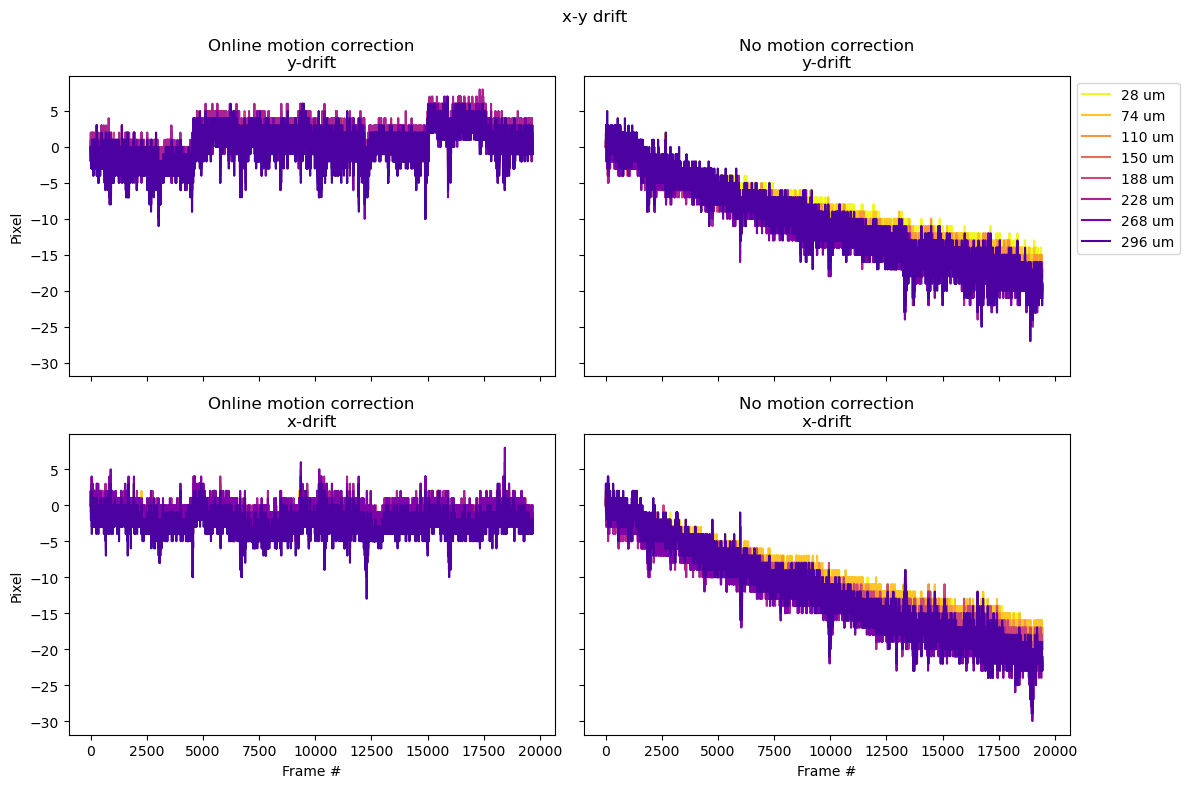

In [67]:
from matplotlib import colormaps as cm
colors = cm.get_cmap('plasma')

fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
for di, depth in enumerate(depth_value_sorted):
    opid = [key for key, value in opid_depths.items() if value == depth]
    parent_opid_ind = np.where(np.array(omc_parent_opid) == opid)[0][0]
    fn = omc_fn_list[parent_opid_ind]
    ops_fn = fn.split('.')[0][:-3] + 'ops.npy'
    ops = np.load(ops_fn, allow_pickle=True).item()
    y_drift = ops['reg_result'][4][0]
    y_drift = y_drift - y_drift[0]
    x_drift = ops['reg_result'][4][1]
    x_drift = x_drift - x_drift[0]
    cm_val = (8-di) / 8
    ax[0,0].plot(y_drift, color=colors(cm_val), label=f'{depth} um')
    ax[1,0].plot(x_drift, color=colors(cm_val), label=f'{depth} um')

    fn = nomc_fn_list[parent_opid_ind]
    ops_fn = fn.split('.')[0][:-3] + 'ops.npy'
    ops = np.load(ops_fn, allow_pickle=True).item()
    y_drift = ops['reg_result'][4][0]
    y_drift = y_drift - y_drift[0]
    x_drift = ops['reg_result'][4][1]
    x_drift = x_drift - x_drift[0]
    ax[0,1].plot(y_drift, color=colors(cm_val), label=f'{depth} um')
    ax[1,1].plot(x_drift, color=colors(cm_val), label=f'{depth} um')
ax[0,1].legend(loc='upper left', bbox_to_anchor=(1,1))
ax[1,0].set_xlabel('Frame #')
ax[1,1].set_xlabel('Frame #')
ax[0,0].set_ylabel('Pixel')
ax[1,0].set_ylabel('Pixel')
ax[0,0].set_title('Online motion correction\ny-drift')
ax[1,0].set_title('Online motion correction\nx-drift')
ax[0,1].set_title('No motion correction\ny-drift')
ax[1,1].set_title('No motion correction\nx-drift')
fig.suptitle('x-y drift')
fig.tight_layout()

## z-drift

In [69]:
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_721291\test_240515_721291')
fn_list = glob(str(data_dir / '*_timeseries_*.tif'))
emf_fn_list = glob(str(data_dir / '*_timeseries_*_emf.tif'))
fn_list = [fn for fn in fn_list if fn not in emf_fn_list]
fn_base = [Path(fn).name.split('.')[0] for fn in fn_list]
fn_base

['240515_721291_global_30min_1366658085_timeseries_00006',
 '240515_721291_nomotioncorrection_timeseries_30min']

In [70]:
mc_i = 0
nomc_i = 1
omc_fn_list = [fn for fn in emf_fn_list if fn_base[mc_i] in fn]
nomc_fn_list = [fn for fn in emf_fn_list if fn_base[nomc_i] in fn]

In [214]:
# manual curating of matched z-stack depths using mouse-qc
opid_depths = {'1364815941': 150,
'1364815944': 188,
'1364815946': 110,
'1364815948': 228,
'1364815949': 74,
'1364815951': 268,
'1364815952': 28,
'1364815955': 296}
depth_value_sorted = np.sort(list(opid_depths.values()))


In [71]:
# find matched split inds between omc and nomc
omc_parent_opid = []
for fn in omc_fn_list:
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        mc_matched_zstack_fn = h['matched_zstack_fn'][()]
        parent_opid = Path(mc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    omc_parent_opid.append(parent_opid)
nomc_parent_opid = []
for fn in nomc_fn_list:
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        nomc_matched_zstack_fn = h['matched_zstack_fn'][()]
        parent_opid = Path(nomc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    nomc_parent_opid.append(parent_opid)
assert np.array([omc_parent_opid[i]==nomc_parent_opid[i] for i in range(len(omc_parent_opid))]).all()

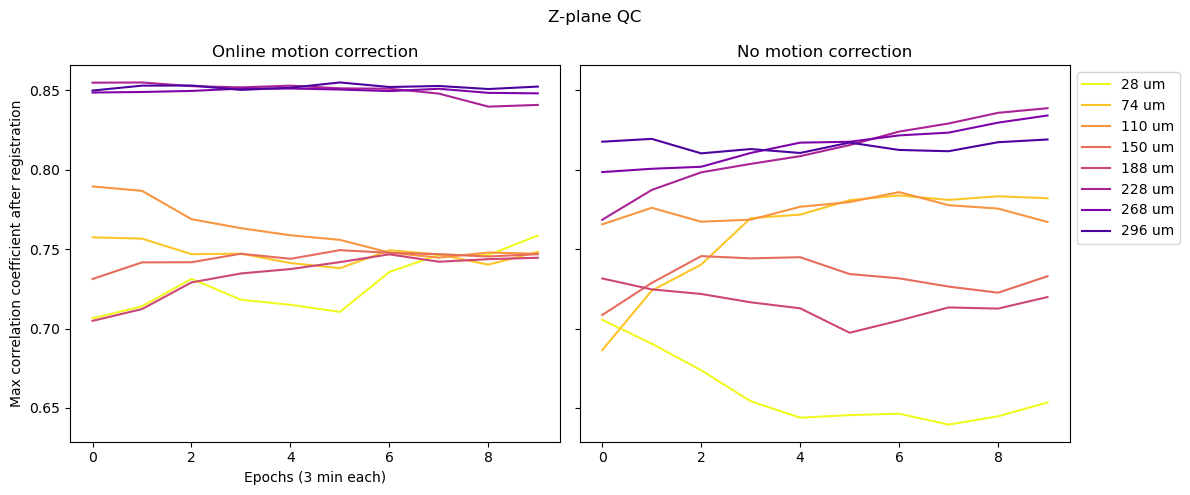

In [84]:
# QC on the registration
fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
for di, depth in enumerate(depth_value_sorted):
    opid = [key for key, value in opid_depths.items() if value == depth]
    parent_opid_ind = np.where(np.array(omc_parent_opid) == opid)[0][0]
    fn = omc_fn_list[parent_opid_ind]
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        corrcoef = h['corrcoef'][:]
    max_corr = [cc.max() for cc in corrcoef]
    cm_val = (8-di) / 8
    ax[0].plot(max_corr, label=f'{depth} um', color=colors(cm_val))
    fn = nomc_fn_list[parent_opid_ind]
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        corrcoef = h['corrcoef'][:]
    max_corr = [cc.max() for cc in corrcoef]
    assert nomc_matched_zstack_fn == mc_matched_zstack_fn
    ax[1].plot(max_corr, label=f'{depth} um', color=colors(cm_val))
ax[1].legend(loc='upper left', bbox_to_anchor=(1,1))
ax[0].set_title('Online motion correction')
ax[1].set_title('No motion correction')
ax[0].set_xlabel('Epochs (3 min each)')
ax[0].set_ylabel('Max correlation coefficient after registration')
fig.suptitle('Z-plane QC')
fig.tight_layout()

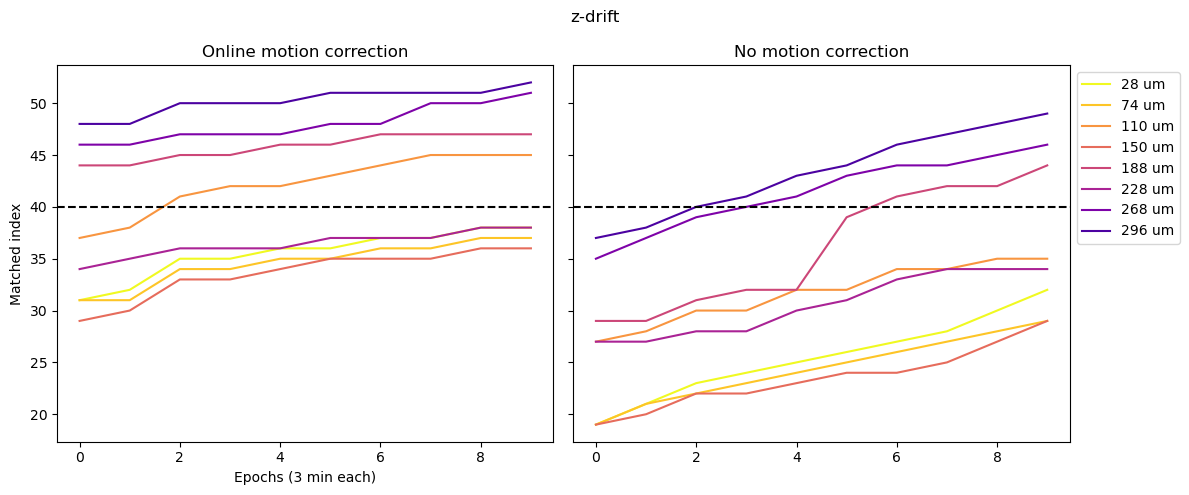

In [73]:
from matplotlib import colormaps as cm
colors = cm.get_cmap('plasma')

fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
for di, depth in enumerate(depth_value_sorted):
    opid = [key for key, value in opid_depths.items() if value == depth]
    parent_opid_ind = np.where(np.array(omc_parent_opid) == opid)[0][0]
    fn = omc_fn_list[parent_opid_ind]
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        mc_matched_inds = h['matched_inds'][:]
        mc_matched_zstack_fn = h['matched_zstack_fn'][()]
    parent_opid = Path(mc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    cm_val = (8-di) / 8
    ax[0].plot(mc_matched_inds, label=f'{depth} um', color=colors(cm_val))
    fn = nomc_fn_list[parent_opid_ind]
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        nomc_matched_inds = h['matched_inds'][:]
        nomc_matched_zstack_fn = h['matched_zstack_fn'][()]
    assert nomc_matched_zstack_fn == mc_matched_zstack_fn
    ax[1].plot(nomc_matched_inds, label=f'{depth} um', color=colors(cm_val))
ax[0].axhline(40, color='k', linestyle='--')
ax[1].axhline(40, color='k', linestyle='--')
ax[1].legend(loc='upper left', bbox_to_anchor=(1,1))
ax[0].set_title('Online motion correction')
ax[1].set_title('No motion correction')
ax[0].set_xlabel('Epochs (3 min each)')
ax[0].set_ylabel('Matched index')
fig.suptitle('z-drift')
fig.tight_layout()

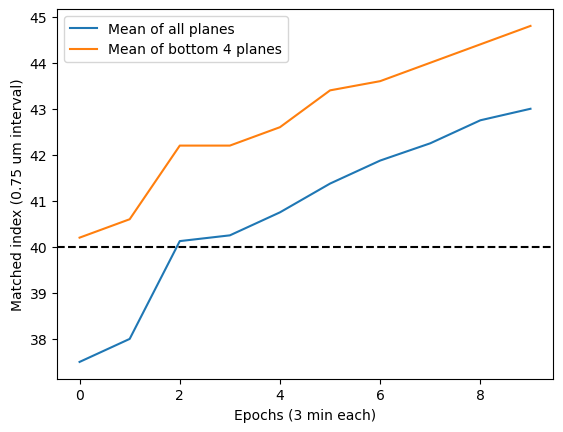

In [76]:
# z-drift from the online motion correction
# Mean of all vs mean of bottom 4
zdrift_omc = []
fig, ax = plt.subplots()
for di, depth in enumerate(depth_value_sorted):
    opid = [key for key, value in opid_depths.items() if value == depth]
    parent_opid_ind = np.where(np.array(omc_parent_opid) == opid)[0][0]
    fn = omc_fn_list[parent_opid_ind]
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        mc_matched_inds = h['matched_inds'][:]
        # mc_matched_zstack_fn = h['matched_zstack_fn'][()]
    # parent_opid = Path(mc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    zdrift_omc.append(mc_matched_inds)
zdrift_omc = np.array(zdrift_omc)    
mean_all = zdrift_omc.mean(axis=0)
mean_bottom = zdrift_omc[3:].mean(axis=0)
ax.plot(mean_all, label='Mean of all planes')
ax.plot(mean_bottom, label='Mean of bottom 4 planes')
ax.set_xlabel('Epochs (3 min each)')
ax.set_ylabel('Matched index (0.75 um interval)')
ax.axhline(40, color='k', linestyle='--')
ax.legend()

In [81]:
for fn in omc_fn_list:
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        corrcoef = h['corrcoef'][:]
    print([cc.max() for cc in corrcoef])

[0.7048194907402422, 0.7122316220835625, 0.7290396971141611, 0.7346822121855446, 0.7374429609406034, 0.7418070721164142, 0.7467081130650889, 0.7420582276944067, 0.7436682374937857, 0.7445489934239654]
[0.7311960363988218, 0.7416520294741598, 0.7417406615931263, 0.747102531827842, 0.7439051247393903, 0.7493446264471116, 0.7476738694460899, 0.7467943902450924, 0.7453509012813987, 0.7468140812082658]
[0.8548156846779686, 0.8549479141335058, 0.8526227937651207, 0.8518589374422195, 0.8529453883125286, 0.8512516742832096, 0.8510238903121058, 0.8479411324382748, 0.8397465758961475, 0.8408045641654986]
[0.7894554597095882, 0.7867021687427902, 0.7688574702658233, 0.7631720514733072, 0.7587226147958857, 0.7558221989049629, 0.7478224061199514, 0.7446317765593168, 0.7478677515957479, 0.747065986368012]
[0.8486240279735979, 0.8489636083130208, 0.8496224404184921, 0.8510924583756982, 0.8511409518155951, 0.85050637339273, 0.8495220112226142, 0.8509754582294495, 0.8484230537642672, 0.8480886415475622]

In [232]:
corrcoef.shape

(10, 81)

[0.2951640452538241,
 0.3027612331498881,
 0.2773318433344576,
 0.29875697566724185,
 0.3307536571190005,
 0.34119160287670686,
 0.3492564926341335,
 0.3700519688353192,
 0.3877313729937194,
 0.3912470737279865]

In [17]:
# match plane to parent opid
# first emf to 20 planes around the center of each zstack (because there can be overlap between zstacks)
num_planes_around = 21
center_zstacks = []
for zstack_fn in zstack_fn_list:
    zstack = tifffile.imread(zstack_fn)
    center_ind = int(np.floor(zstack.shape[0]/2))
    center_zstack = zstack[center_ind - num_planes_around//2 : center_ind + num_planes_around//2]
    center_zstacks.append(center_zstack)

In [19]:
center_zstacks[0].shape

(20, 512, 512)

In [18]:
first_emfs = []
for emf_fn in emf_fn_list:
    emf = tifffile.imread(emf_fn)
    first_emfs.append(emf[0])

In [20]:
first_emfs[0].shape

(512, 512)

In [23]:
# takes about 8 min
sr = StackReg(StackReg.AFFINE)
corrcoef = np.zeros((len(first_emfs), len(center_zstacks), center_zstacks[0].shape[0]))
for i, emf in enumerate(first_emfs):
    for j, zstack in enumerate(center_zstacks):
        for k, zstack_plane in enumerate(zstack):
            emf_reg = sr.register_transform(zstack_plane, emf)
            cc = np.corrcoef(zstack_plane.flatten(), emf_reg.flatten())[0,1]
            corrcoef[i,j,k] = cc


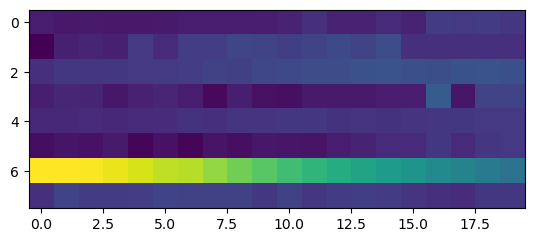

In [32]:
import matplotlib.pyplot as plt
plt.imshow(corrcoef[7])

In [35]:
matched_zstack_inds = [np.argmax(np.sum(ccmat, axis=1)) for ccmat in corrcoef]
assert len(matched_zstack_inds) == len(np.unique(matched_zstack_inds))

In [46]:
emf_i = 7
emf_fn = emf_fn_list[emf_i]
matched_zstack_fn = zstack_fn_list[matched_zstack_inds[emf_i]]

In [47]:
emf = tifffile.imread(emf_fn)
zstack = tifffile.imread(matched_zstack_fn)

In [53]:
def rolling_average_zstack(zstack, rolling_window_flank=2):
    new_zstack = np.zeros(zstack.shape)
    for i in range(zstack.shape[0]):
        new_zstack[i] = np.mean(zstack[max(0, i-rolling_window_flank) : min(zstack.shape[0], i+rolling_window_flank), :, :],
                                axis=0)
    return new_zstack

In [56]:
emf.min()

737.2775744903294

In [60]:
assert emf.min() > 0
valid_pix_threshold = emf.min()/10
num_pix_threshold = emf.shape[1] * emf.shape[2] / 3
new_zstack = rolling_average_zstack(zstack)
corrcoef_emf = np.zeros((len(emf), new_zstack.shape[0]))
tmat_list_emf = []
sr = StackReg(StackReg.AFFINE)
for i, fov in enumerate(emf):
    tmat_list = []
    temp_cc = []
    for j, zplane in enumerate(new_zstack):
        tmat = sr.register(zplane, fov)
        fov_reg = sr.transform(fov, tmat=tmat)
        valid_y, valid_x = np.where(fov_reg > valid_pix_threshold)
        if len(valid_y) > num_pix_threshold:
            temp_cc.append(np.corrcoef(zplane.flatten(), fov_reg.flatten())[0,1])
            tmat_list.append(tmat)
        else:
            temp_cc.append(0)
            tmat_list.append(np.zeros((3,3)))
    temp_ind = np.argmax(temp_cc)
    tmat = tmat_list[temp_ind]
    fov_reg = sr.transform(fov, tmat=tmat)
    tmat_list_emf.append(tmat)
    
    for j, zplane in enumerate(new_zstack):
        corrcoef_emf[i,j] = np.corrcoef(zplane.flatten(), fov_reg.flatten())[0,1]
    


In [50]:
np.argmax(corrcoef_emf2[0])

29

In [49]:
np.argmax(corrcoef_emf2[-1])

37

In [51]:
np.argmax(corrcoef_emf[0])

42

In [44]:
np.argmax(corrcoef_emf[-1])

46

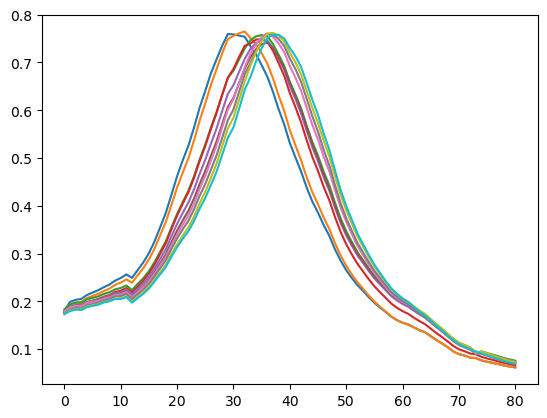

In [59]:
fig, ax = plt.subplots()
for cc in corrcoef_emf:
    ax.plot(cc)

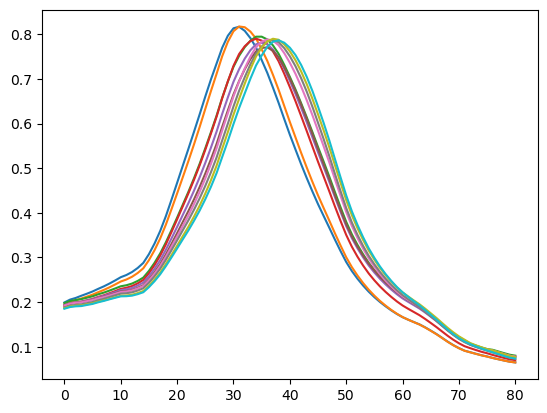

In [61]:
fig, ax = plt.subplots()
for cc in corrcoef_emf:
    ax.plot(cc)

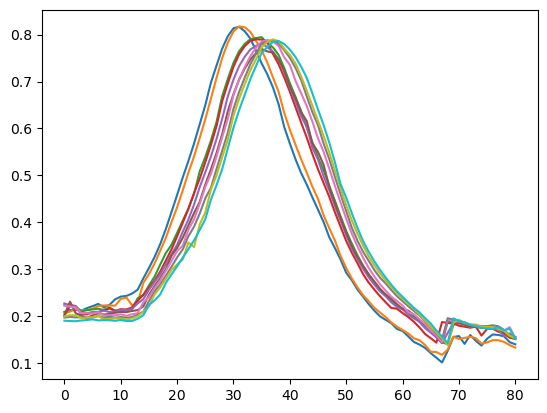

In [55]:
fig, ax = plt.subplots()
for cc in corrcoef_emf2:
    ax.plot(cc)

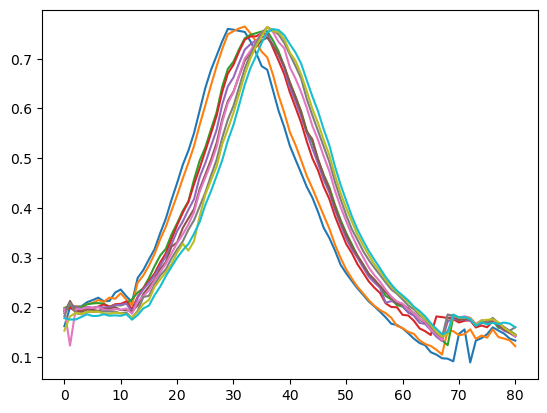

In [52]:
fig, ax = plt.subplots()
for cc in corrcoef_emf2:
    ax.plot(cc)

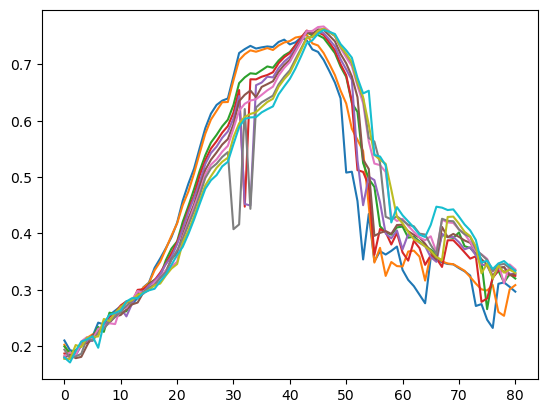

In [41]:
fig, ax = plt.subplots()
for cc in corrcoef_emf:
    ax.plot(cc)

In [40]:
corrcoef_emf

array([[0.20996985, 0.19259316, 0.19044886, 0.20147819, 0.21138371,
        0.21733436, 0.24163093, 0.23844679, 0.25499268, 0.2629214 ,
        0.2706868 , 0.27905831, 0.27445834, 0.28549375, 0.30420649,
        0.31257362, 0.3387536 , 0.35555969, 0.3737223 , 0.3934955 ,
        0.41895283, 0.45823368, 0.48821919, 0.51485167, 0.55133768,
        0.5867462 , 0.61251334, 0.62799704, 0.63561438, 0.63950032,
        0.6794215 , 0.72016376, 0.72711514, 0.73286382, 0.72811957,
        0.73023763, 0.73182375, 0.73076202, 0.73978161, 0.74389722,
        0.73547808, 0.73925901, 0.74749411, 0.74258236, 0.72649048,
        0.72214306, 0.70783518, 0.68824481, 0.66761491, 0.63965623,
        0.50796246, 0.50947252, 0.4573491 , 0.35375598, 0.43458651,
        0.35026526, 0.36837617, 0.362476  , 0.36897645, 0.37667059,
        0.33512956, 0.31740559, 0.30639424, 0.29125627, 0.27600077,
        0.35751715, 0.35325265, 0.34862969, 0.34575353, 0.3450462 ,
        0.33840442, 0.33277542, 0.32512702, 0.27

In [ ]:
corrcoef = np.zeros(stack_clahe.shape[0])
fov_reg_stack = np.zeros_like(stack)
tmat_list = []
for pi in range(len(corrcoef)):
    tmat = sr.register(stack_clahe[pi, :, :], fov_clahe)
    # Apply the transformation matrix to the FOV registered using phase correlation
    fov_reg = sr.transform(fov, tmat=tmat)
    if use_valid_pix:
        valid_y, valid_x = np.where(fov_reg > valid_pix_threshold)
        corrcoef[pi] = np.corrcoef(
            stack_pre[pi, valid_y, valid_x].flatten(), fov_reg[valid_y, valid_x].flatten())[0, 1]
    else:
        corrcoef[pi] = np.corrcoef(
            stack_pre[pi, :, :].flatten(), fov_reg.flatten())[0, 1]
    fov_reg_stack[pi, :, :] = fov_reg
    tmat_list.append(tmat)
matched_plane_index = np.argmax(corrcoef)
tmat = tmat_list[matched_plane_index]